PPMI NC subjects from  2010  to  2018


'All ADNI2 subjects types:'

array(['CN', 'AD', 'LMCI', 'EMCI', 'SMC'], dtype=object)

/usr/local/miniconda/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

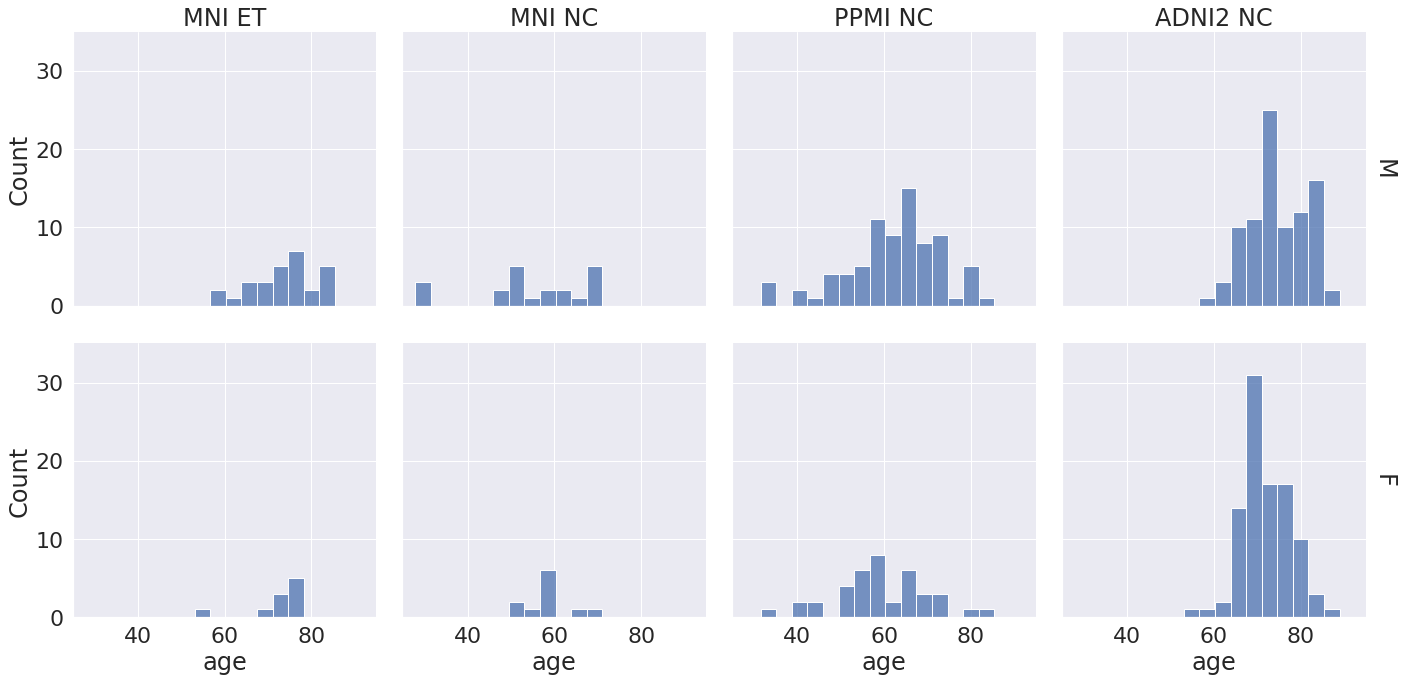

In [33]:
## Preproc PPMI and NC tab
from pathlib import Path
import pandas as pd
import seaborn as sns
out_dir = Path("/output")
mni_file = out_dir/'freesurfer_out_preped.csv'
ppmi_file = out_dir/'data'/'ppmi'/'NC_PPMI'/'3T_T1_NC_5_08_2021.csv'
adni_file = out_dir/'data'/'ADNI'/'ADNIMERGE.csv'

# MNI ET dataset preproc
mni_tab  = pd.read_csv(mni_file, sep=',', header=0, index_col=0)
mni_tab['subject']=mni_tab.index
mni_nc_tab  = mni_tab[mni_tab['diagnosis']=='NC'][['age', 'sex', 'subject']]; mni_nc_tab['group']='MNI NC'
mni_et_tab  = mni_tab[mni_tab['diagnosis']=='ET'][['age', 'sex', 'subject']]; mni_et_tab['group']='MNI ET'
# PPMI NC prepproc
ppmi_tab = pd.read_csv(ppmi_file, sep=',', header=0, index_col=0)
# PPMI aquisition time span
ppmi_tab['acq_year']=ppmi_tab['Acq Date'].apply(lambda x: int(x[-4:]))
print('PPMI NC subjects from ', min(ppmi_tab['acq_year']), ' to ', max(ppmi_tab['acq_year']))
# take the most recent visit and remove duplicates
ppmi_tab['visit_last'] = ppmi_tab.groupby(['Subject'])['Visit'].transform(max)
ppmi_tab = ppmi_tab[ppmi_tab['Visit']==ppmi_tab['visit_last']]
ppmi_tab.sort_values(by='Subject', ascending=False)
ppmi_tab['duplicate']=ppmi_tab['Subject'].duplicated()
# detailed duplicate information
#display(ppmi_tab[ppmi_tab['duplicate']==True])
#display(ppmi_tab[ppmi_tab['Subject']==4085])
#display(ppmi_tab[ppmi_tab['Subject']==3571])
#display(ppmi_tab[ppmi_tab['Subject']==3551])
#display(ppmi_tab[ppmi_tab['Subject']==3361])
ppmi_tab=ppmi_tab.drop(['I864811', 'I864810','I615265','I548986','I581043'])
ppmi_nc_tab = ppmi_tab[['Age','Sex']]
ppmi_nc_tab = ppmi_nc_tab.rename(columns=str.lower); ppmi_nc_tab['group']='PPMI NC'
ppmi_nc_tab['subject']=ppmi_nc_tab.index

# preproc ANDI tab
adni_tab = pd.read_csv(adni_file, sep=',', header=0, index_col=0)
display('All ADNI2 subjects types:')
display(adni_tab['DX_bl'].unique())
# select cohort
adni_tab = adni_tab[adni_tab['ORIGPROT']=='ADNI2']
# select the normal control
adni_nc_tab = adni_tab[adni_tab['DX_bl']=='CN']
adni_nc_tab[['subject', 'age', 'group', 'sex','visit']] = adni_nc_tab[['PTID', 'AGE', 'ORIGPROT', 'PTGENDER','VISCODE']]
def trans_visit_adni(x):
    if x=='m03': return 3;
    elif x=='m06': return 6; 
    elif x=='m12': return 12;
    elif x=='m18': return 18;
    elif x=='m24': return 24;
    elif x=='m30': return 30;
    elif x=='m36': return 36;
    elif x=='bl': return 0;
    else: return -1;
def trans_sex_adni(x):
    if x=='Male': return 'M';
    elif x=='Female': return 'F';
adni_nc_tab['visit']=adni_nc_tab['VISCODE'].apply(lambda x: trans_visit_adni(x))
adni_nc_tab['sex']=adni_nc_tab['PTGENDER'].apply(lambda x: trans_sex_adni(x))
adni_nc_tab['visit_last'] = adni_nc_tab.groupby(['PTID'])['visit'].transform(max)
adni_nc_tab = adni_nc_tab[adni_nc_tab['visit']==adni_nc_tab['visit_last']]
adni_nc_tab['subject']=adni_nc_tab['PTID']; adni_nc_tab['age']=adni_nc_tab['AGE']; adni_nc_tab['group']=adni_nc_tab['ORIGPROT'];
adni_nc_tab=adni_nc_tab[['subject','age','sex','group']]; adni_nc_tab['group']='ADNI2 NC'

data_tab = pd.concat([mni_et_tab, mni_nc_tab, ppmi_nc_tab, adni_nc_tab],ignore_index=True)

# plot disctribution
SEX_ORDER=['M','F']; GROUP_ORDER=['MNI ET','MNI NC','PPMI NC','ADNI2 NC']
LIM_AGE=(25, 95); LIM_CNT=(0, 35); 

sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
dist_plt=sns.displot(data_tab, x="age", row='sex', col='group', 
                     facet_kws=dict(margin_titles=True),
                     row_order=SEX_ORDER, col_order=GROUP_ORDER)
dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")
dist_plt.set(ylim=LIM_CNT); dist_plt.set(xlim=LIM_AGE); 
#data_tab

In [62]:
# comparison of distributions
def distr_test(g1, g2):
    import scipy
    import statsmodels.stats.weightstats as ws
    # group are dataframes with M/F as sex and int as age
    g1_name=list(g1['group'])[0]; g2_name= list(g2['group'])[0];
    g1_m = g1[g1['sex']=='M'].shape[0]; g1_f = g1[g1['sex']=='F'].shape[0];
    g2_m = g2[g2['sex']=='M'].shape[0]; g2_f = g2[g2['sex']=='F'].shape[0];
    print( g1_name, '/', g2_name,' :')
    print('M/F: ', g1_m, '/', g1_f, '; ', g2_m, '/', g2_f)
    print('age mean: ', g1['age'].mean(),  '/', g2['age'].mean())
    print('age std: ',  g1['age'].std(), '/'  , g2['age'].std())
    # chi-square test for sex
    chisq, chi_pval = scipy.stats.chi2_contingency([[g1_m, g1_f], [g2_m, g2_f]])[:2]
    print('Sex Chisqure test: \n','chisq =%.6f, pvalue = %.6f'%(chisq, chi_pval));
    # t-test for age 
    t_stat,t_pval,t_df=ws.ttest_ind(g1['age'], g2['age'], alternative='two-sided', usevar='pooled')
    print('Age 2-sided independent t-test (tstat, pval, df): \n','tstat =%.6f, pvalue = %.6f, df = %i'%(t_stat, t_pval, t_df),'\n\n')
    return
# report
distr_test(data_tab[data_tab['group']=='MNI ET'], data_tab[data_tab['group']=='MNI NC'])
distr_test(data_tab[data_tab['group']=='MNI ET'], data_tab[data_tab['group']=='PPMI NC'])
distr_test(data_tab[data_tab['group']=='MNI ET'], data_tab[data_tab['group']=='ADNI2 NC'])

MNI ET / MNI NC  :
M/F:  28 / 10 ;  21 / 11
age mean:  73.39473684210526 / 56.3125
age std:  6.9653174533666125 / 11.093262994762531
Sex Chisqure test: 
 chisq =0.222039, pvalue = 0.637490
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =7.838579, pvalue = 0.000000, df = 68 


MNI ET / PPMI NC  :
M/F:  28 / 10 ;  78 / 39
age mean:  73.39473684210526 / 61.23931623931624
age std:  6.9653174533666125 / 11.101141268332523
Sex Chisqure test: 
 chisq =0.369102, pvalue = 0.543494
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =6.348213, pvalue = 0.000000, df = 153 


MNI ET / ADNI2 NC  :
M/F:  28 / 10 ;  90 / 97
age mean:  73.39473684210526 / 73.39572192513369
age std:  6.9653174533666125 / 6.2634957850341335
Sex Chisqure test: 
 chisq =7.277393, pvalue = 0.006983
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =-0.000867, pvalue = 0.999309, df = 223 




# matching problems:
1. What should we do if we have enough matched subjects but not for each sex, by now I just include to the total number we need;
2. tbd

In [95]:
# matching by percentile
import numpy as np
import math

nc_needed=116; 
nc_m_needed=round(nc_needed*(mni_et_m/(mni_et_m+mni_et_f))); 
nc_f_needed=round(nc_needed*(mni_et_f/(mni_et_m+mni_et_f))); 

def age2percentile(age_array):
    import numpy as np
    percentiles = np.argsort(np.argsort(age_array)) * 100. / (len(age_array) - 1)
    return percentiles

def dist_score_L2(age, group_age):
    #group_size = len(group_age);
    score=np.sqrt(sum(np.power(group_age-age,2)))
    return score

def distr_match(distr_target, n_target, distr_source, match_method, para):
    #inlcuding all the subjects within the percentile of target distribution
    import pandas as pd
    # parameters resolve
    percent_th = para['percentile']; percent_th_c = 100-para['percentile'];
    ## default 
    res=distr_source;
    distr_target_m = distr_target[distr_target['sex']=='M']; distr_target_f=distr_target[distr_target['sex']=='F'];
    distr_source_m = distr_source[distr_source['sex']=='M']; distr_source_f=distr_source[distr_source['sex']=='F'];
    n_target_m = round(nc_needed*len(distr_target_m)/(len(distr_target)));  n_target_f = nc_needed-n_target_m;
    target_m_mean = distr_target_m['age'].mean(); target_m_std = distr_target_m['age'].std();
    target_f_mean = distr_target_f['age'].mean(); target_f_std = distr_target_f['age'].std(); 
    print('Expecting ',n_target_m,' M and ',n_target_f,'F')
    
    ## differenct methods
    if match_method=='percentile':
        # get percentile thresholds by sex
        th_m_lower = np.percentile(distr_target_m['age'], percent_th); th_m_higher = np.percentile(distr_target_m['age'], percent_th_c);
        th_f_lower = np.percentile(distr_target_f['age'], percent_th); th_f_higher = np.percentile(distr_target_f['age'], percent_th_c); 
        res_m_sel=distr_source_m[(distr_source_m['age']>=th_m_lower)&(distr_source_m['age']<=th_m_higher)];
        res_f_sel=distr_source_f[(distr_source_f['age']>=th_f_lower)&(distr_source_f['age']<=th_f_higher)];
        res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
        n_matched_m = len(res_m_sel); n_matched_f = len(res_f_sel);
        print('Percentile matching with percentile=', percent_th, ' , and get ', len(res_sel), ' matched subjects.')
        if n_target_m <= n_matched_m:
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more = n_target_f-n_matched_f;
                res_m_sel2 = res_m_sel.sample(n=(n_target_m+n_more), random_state=1);
                res_sel = pd.concat([res_m_sel2, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel2), '/', len(res_f_sel) )
                return res_sel
        else:
            if n_target_f <= n_matched_f:
                n_more = n_matched_f-n_target_f;
                res_f_sel1 = res_f_sel.sample(n=n_target_f+n_more, random_state=1);
                res_sel = pd.concat([res_m_sel, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel1) )
                return res_sel
            else:
                res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel) )
                print('Fail to get enough matched subjects!')
                return res_sel
    elif match_method=='target_mean':
        distr_source_m['target_score'] = (distr_source_m['age']-target_m_mean)/target_m_std;
        distr_source_f['target_score'] = (distr_source_f['age']-target_f_mean)/target_f_std;
        distr_source_m['percentile'] = age2percentile(distr_source_m['target_score']); 
        distr_source_f['percentile'] = age2percentile(distr_source_f['target_score']);
        res_m_sel=distr_source_m[(distr_source_m['percentile']>=percent_th)&(distr_source_m['percentile']<=percent_th_c)];
        res_f_sel=distr_source_f[(distr_source_f['percentile']>=percent_th)&(distr_source_f['percentile']<=percent_th_c)];
        res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
        n_matched_m = len(res_m_sel); n_matched_f = len(res_f_sel);
        print('Percentile based on ET mean matching with percentile=', percent_th, ' , and get ', len(res_sel), ' matched subjects.')
        if n_target_m <= n_matched_m:
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more = n_target_f-n_matched_f;
                res_m_sel2 = res_m_sel.sample(n=(n_target_m+n_more), random_state=1);
                res_sel = pd.concat([res_m_sel2, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel2), '/', len(res_f_sel) )
                return res_sel
        else:
            if n_target_f <= n_matched_f:
                n_more = n_matched_f-n_target_f;
                res_f_sel1 = res_f_sel.sample(n=n_target_f+n_more, random_state=1);
                res_sel = pd.concat([res_m_sel, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel1) )
                return res_sel
            else:
                res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel) )
                print('Fail to get enough matched subjects!')
                return res_sel
    elif match_method=='l2_cut':
        age_tar_m=distr_target_m['age'];  age_tar_f=distr_target_f['age'];
        distr_source_m['L2_score'] = distr_source_m['age'].map(lambda x: dist_score_L2(x, age_tar_m));
        distr_source_f['L2_score'] = distr_source_f['age'].map(lambda x: dist_score_L2(x, age_tar_f));
        th_m_cut = np.percentile(distr_source_m['age'], percent_th_c);  th_f_cut = np.percentile(distr_source_f['age'], percent_th_c);
        res_m_sel=distr_source_m[distr_source_m['L2_score']<th_m_cut]; res_f_sel=distr_source_f[distr_source_f['L2_score']<th_f_cut];
        res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
        n_matched_m = len(res_m_sel); n_matched_f = len(res_f_sel);
        print('L2-cut based matching with cut_percent=', percent_th, ' , and get ', len(res_sel), ' matched subjects.')
        if n_target_m <= n_matched_m:
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more = n_target_f-n_matched_f;
                res_m_sel2 = res_m_sel.sample(n=(n_target_m+n_more), random_state=1);
                res_sel = pd.concat([res_m_sel2, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel2), '/', len(res_f_sel) )
                return res_sel
        else:
            if n_target_f <= n_matched_f:
                n_more = n_matched_f-n_target_f;
                res_f_sel1 = res_f_sel.sample(n=n_target_f+n_more, random_state=1);
                res_sel = pd.concat([res_m_sel, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel1) )
                return res_sel
            else:
                res_sel = pd.concat([res_m_sel, res_f_sel], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel), '/', len(res_f_sel) )
                print('Fail to get enough matched subjects!')
                return res_sel
    elif match_method=='new_method':
        pass
    else:
        print(match_method, ' is not supported yet!!!')
    return res
####

## use
para={'percentile':5}
#match
percentile_matched=distr_match(data_tab[data_tab['group']=='MNI ET'], nc_needed, data_tab[data_tab['group']=='ADNI2 NC'], 'l2_cut', para)
# test
distr_test(data_tab[data_tab['group']=='MNI ET'], percentile_matched)
percentile_matched

Expecting  85  M and  31 F
L2-cut based matching with cut_percent= 5  , and get  186  matched subjects.
Get matched M/F:  85 / 31
MNI ET / ADNI2 NC  :
M/F:  28 / 10 ;  85 / 31
age mean:  73.39473684210526 / 74.12155172413793
age std:  6.9653174533666125 / 6.501087615154101
Sex Chisqure test: 
 chisq =0.026249, pvalue = 0.871293
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =-0.587648, pvalue = 0.557641, df = 152 




/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age,group,sex,subject,L2_score
0,67.8,ADNI2 NC,M,137_S_4520,48.618104
1,75.0,ADNI2 NC,M,011_S_4278,38.013156
2,83.7,ADNI2 NC,M,029_S_4279,64.870024
3,59.9,ADNI2 NC,M,128_S_4599,81.926064
4,70.4,ADNI2 NC,M,035_S_4464,41.195631
5,65.3,ADNI2 NC,M,029_S_4585,57.980341
6,72.6,ADNI2 NC,M,082_S_4428,37.797884
7,73.3,ADNI2 NC,M,006_S_4485,37.418177
8,74.0,ADNI2 NC,M,016_S_4638,37.403208
9,71.3,ADNI2 NC,M,041_S_4427,39.427402


/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

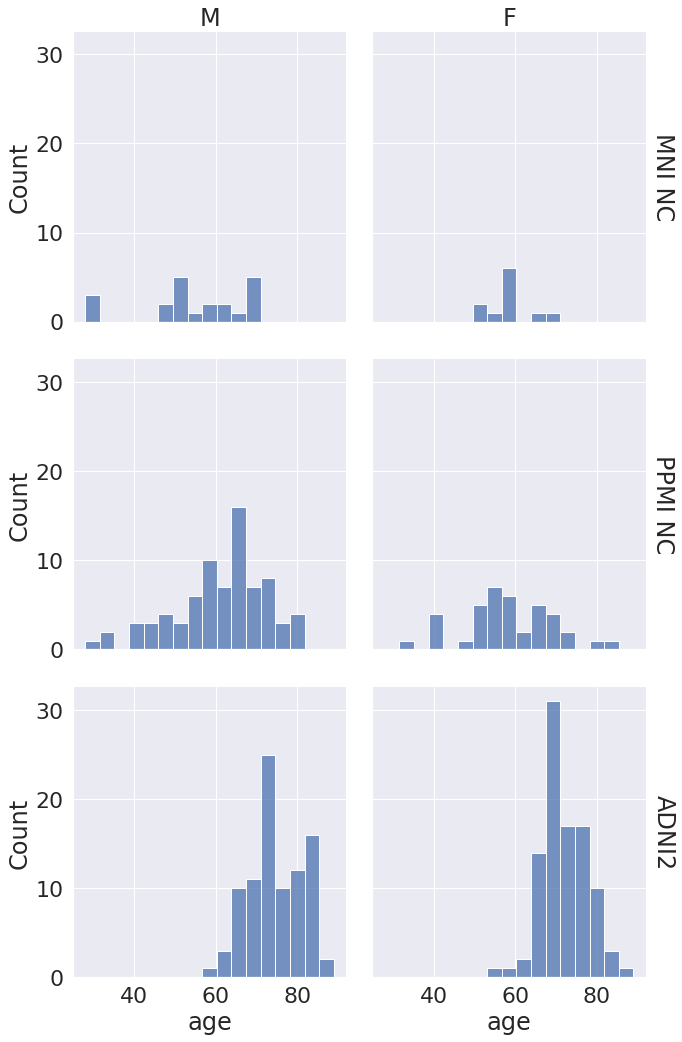

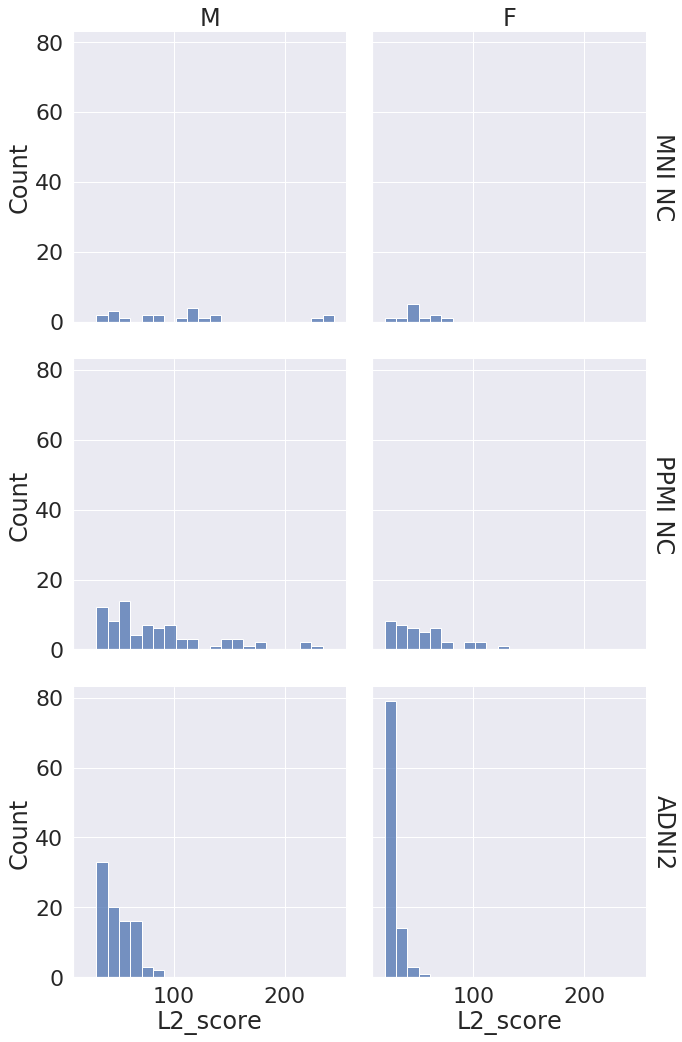

In [10]:
# L1 and L2 distance matching
# should we match by 
def dist_score_L2(age, group_age):
    #group_size = len(group_age);
    score=np.sqrt(sum(np.power(group_age-age,2)))
    return score
# test: dist_score_L2(10, mni_et_tab['age'])
age_et=mni_et_tab['age']; 
age_et_m=mni_et_tab[mni_et_tab['sex']=='M']['age']; 
age_et_f=mni_et_tab[mni_et_tab['sex']=='F']['age'];
mni_nc_m=mni_nc_tab[mni_nc_tab['sex']=='M']; mni_nc_f=mni_nc_tab[mni_nc_tab['sex']=='F']
ppmi_nc_m=ppmi_nc_tab[ppmi_nc_tab['sex']=='M']; ppmi_nc_f=ppmi_nc_tab[ppmi_nc_tab['sex']=='F'];
adni_nc_m=adni_tab[adni_tab['sex']=='M']; adni_nc_f=adni_tab[adni_tab['sex']=='F'];
#
mni_nc_m['L2_score']=mni_nc_m['age'].map(lambda x: dist_score_L2(x, age_et_m))
mni_nc_f['L2_score']=mni_nc_f['age'].map(lambda x: dist_score_L2(x, age_et_f))
ppmi_nc_m['L2_score']=ppmi_nc_m['age'].map(lambda x: dist_score_L2(x, age_et_m))
ppmi_nc_f['L2_score']=ppmi_nc_f['age'].map(lambda x: dist_score_L2(x, age_et_f))
adni_nc_m['L2_score']=adni_nc_m['age'].map(lambda x: dist_score_L2(x, age_et_m))
adni_nc_f['L2_score']=adni_nc_f['age'].map(lambda x: dist_score_L2(x, age_et_f))
l2_matched_nc = pd.concat([mni_nc_m, mni_nc_f, ppmi_nc_m, ppmi_nc_f,adni_nc_m,adni_nc_f])

# plot
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
dist_plt=sns.displot(l2_matched_nc, x="age", row="group", col='sex',
                     facet_kws=dict(margin_titles=True),
                     col_order=SEX_ORDER, row_order=['MNI NC','PPMI NC','ADNI2'])
dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")
#dist_plt.set(ylim=LIM_CNT); dist_plt.set(xlim=LIM_AGE); 
dist_plt=sns.displot(l2_matched_nc, x="L2_score", row="group", col='sex',
                     facet_kws=dict(margin_titles=True),
                     col_order=SEX_ORDER, row_order=['MNI NC','PPMI NC','ADNI2'])
dist_plt.set_titles(col_template="{col_name}", row_template="{row_name}")

In [8]:
# exact matching by discrete distributions, may not applicable ()
# get distribution
vc_et_m=mni_et_tab[mni_et_tab['sex']=='M']['age'].value_counts().to_frame(); vc_et_m['cnt_et']=vc_et_m['age'] ;vc_et_m['age']=vc_et_m.index;
vc_et_f=mni_et_tab[mni_et_tab['sex']=='F']['age'].value_counts().to_frame(); vc_et_f['cnt_et']=vc_et_f['age'] ;vc_et_f['age']=vc_et_f.index;
vc_nc_m=nc_tab[nc_tab['sex']=='M']['age'].value_counts().to_frame(); vc_nc_m['cnt_nc']=vc_nc_m['age'] ;vc_nc_m['age']=vc_nc_m.index;
vc_nc_f=nc_tab[nc_tab['sex']=='F']['age'].value_counts().to_frame(); vc_nc_f['cnt_nc']=vc_nc_f['age'] ;vc_nc_f['age']=vc_nc_f.index;
# merge distribution
cnt_m_all=vc_et_m.merge(vc_nc_m, how='outer', left_on='age', right_on='age', sort=1);
cnt_m_all['rate']=cnt_m_all['cnt_nc']/cnt_m_all['cnt_et']

cnt_f_all=vc_et_f.merge(vc_nc_f, how='outer', left_on='age', right_on='age', sort=1);
cnt_f_all['rate']=cnt_f_all['cnt_nc']/cnt_f_all['cnt_et']
#display(cnt_m_all)
#display(cnt_f_all)

In [9]:
# matching by span of age (10 years)
BIN_AGE = [0,40,50,60,70,80,100];
#display(pd.cut(mni_et_tab['age'], BIN_AGE).value_counts())
#display(pd.cut(mni_nc_tab['age'], BIN_AGE).value_counts())
#display(pd.cut(ppmi_nc_tab['age'], BIN_AGE).value_counts())